In [1]:
import os
import tempfile
import matplotlib.pylab as plt
import numpy as np
import requests

from torch.utils.data import DataLoader

from torchgeo.datasets import NAIP, ChesapeakeDE, stack_samples, RasterDataset, BoundingBox, GeoDataset
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler, RandomBatchGeoSampler
from torchgeo.samplers.utils import get_random_bounding_box

from typing import Any, Callable, Dict, Optional, Iterator, Union, Tuple, List
from rasterio.crs import CRS

import random
import torch
import math

## Setup and test regular sampler

In [2]:
class ModisFireCCI(RasterDataset):
    """Abstract base class for all MODIS Fire CCI Burned Area datasets.

    `MODIS Fire_cci Burned Area Dataset: <https://geogra.uah.es/fire_cci/firecci51.php>`_
    This dataset was developed by ESA, utilising the MODIS satellite. The dataset contains
    information at both PIXEL (~250m) and GRID (0.25 degrees) resolutions. A variety of 
    useful information is contained within the datasets including Julian Day of burn, 
    confidence level of burn etc.
    For more information, see:
    * `User Guide
      <https://climate.esa.int/media/documents/Fire_cci_D4.2_PUG-MODIS_v1.0.pdf>`_
    """
    
class Modis_JD(ModisFireCCI):
    """
    Class for the burn day (in Julian Days) that a burned area is first seen on.
    
    Possible values (mask not image): 
        -2 = pixel not of burnable type e.g. water, urban areas or permanent snow/ice.
        -1 = pixel not observed in the month (possible cloud cover etc)
         0  = pixel is not burned 
        [1,366] = Julian Day of first detection when the pixel is burned 
    """

    filename_glob = "*JD.tif" 
    filename_regex = "(?P<date>\d{6})\S{33}(?P<tile_number>\d).*"
    date_format = "%Y%m" 
    is_image = False
    all_bands = ["Julian Day"]
    

In [3]:
ds = Modis_JD("Binarized")
print(ds)

Modis_JD Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=22.944655155023842, maxx=32.100509032624856, miny=50.50204611239522, maxy=53.04421598961974, mint=1583020799.999999, maxt=1590965999.999999)
    size: 3


In [4]:
# NOTE: batch_size = number of batches within each sample instance (index of sample).
#       length = total number of samples per epoch, i.e. length/batch_size = samples taken per individual batch

sampler = RandomBatchGeoSampler(ds, size=0.5, batch_size=2, length=6)

torch.Size([1, 223, 223])


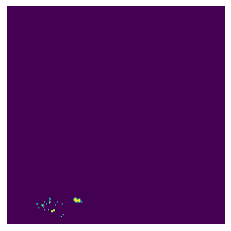

torch.Size([1, 223, 223])


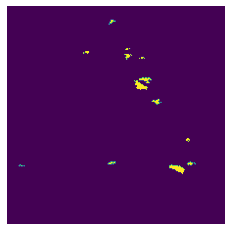

torch.Size([1, 223, 223])


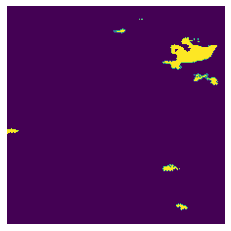

In [5]:
# NOTE: We require the batch_sampler argument now. The samples must also have an extra index to indicate the batch_num to use
dl = DataLoader(ds, batch_sampler=sampler, collate_fn=stack_samples)

for sample in dl:
    mask = sample['mask'][0]
    print(mask.shape)
    ds.plot(mask)


## Make ConstrainedRandomGeoSampler class

In [6]:
class ConstrainedRandomGeoSampler(RandomGeoSampler):
    """Returns samples that meet the constraints specified:
        1. Proportion of samples with a burn proportion < 'burn_th': 'no_burn_prop'
        2. The rest of the samples will make up 1-'no_burn_prop' proportion and have a burn proportion > 'burn_th'
    
    Args:
        dataset: the dataset to take samples from.
        size: size of patch in lat/lon. 
        length: number of samples to take per epoch.
        not_burned_prop: proportion of returned samples present that are "not burned". This may be no burn/some burn.
        burn_th: minimum threshold proportion required for a sample to be classed as "burned.
        roi: region of interest to take samples from.
        
    Returns: 
        constrained_samples: set of samples that meet the specified constraints.
    """
    
    # Setup the attributes required for constraint implementation 
    not_burned_samples_required = None
    burn_samples_required = None
    not_burned_prop = None
    burn_th = None
    
    # Define the constructor 
    def __init__(
        self,
        dataset: GeoDataset,
        size: Union[Tuple[float, float], float],
        length: int,
        not_burned_prop: float,
        burn_th: float,
        roi: Optional[BoundingBox] = None,
    ) -> None:

        # Use init from RandomGeoSampler parent class
        super().__init__(dataset, size, length)
        
        # Save the input constraints and dataset to the object 
        self.dataset = dataset
        self.not_burned_prop = not_burned_prop
        self.burn_th = burn_th
        
        # Set the number of samples required of not burned/burned types
        self.not_burned_samples_required = math.floor(not_burned_prop * self.length)
        self.burn_samples_required = self.length - self.not_burned_samples_required
        
    
    def __iter__(self) -> Iterator[BoundingBox]:
        """Defines a generator function of areas to sample next.
        
        Returns:
            (minx, maxx, miny, maxy, mint, maxt) coordinates to index a dataset
        """
        
        # While we still require more samples, generate random bounding boxes 
        while self.not_burned_samples_required != 0 or self.burn_samples_required != 0:
            
            # Choose a random tile
            hit = random.choice(self.hits)
            bounds = BoundingBox(*hit.bounds)

            # Choose a random sample within that tile
            bounding_box = get_random_bounding_box(bounds, self.size, self.res)
            
            # Find the burn proportion of that sample
            burn_prop = self.get_burn_proportion(bounding_box)
            
            # If we have a "not-burned" sample and we require "not-burned" samples
            if burn_prop < self.burn_th and self.not_burned_samples_required != 0:
                #print("No burn sample:")
                self.not_burned_samples_required -= 1
                yield bounding_box
                
            # If we have a "burn" sample and we require "burn" samples    
            elif burn_prop >= self.burn_th and self.burn_samples_required != 0:
                #print("Burn sample:")
                self.burn_samples_required -= 1
                yield bounding_box
                
        # If all required samples generated, reset requirements for next sampler call 
        self.not_burned_samples_required = math.floor(self.not_burned_prop * self.length)
        self.burn_samples_required = self.length - self.not_burned_samples_required
                
            
    def get_burn_proportion(self, bounding_box):
        """Returns the burn proportion found within a given bounding box.
        
        Returns:
            burn_prop: the burn proportion present within the bounding box. 
        """
        
        # Obtain the burn data within the bounding box
        burn_data = self.dataset[bounding_box]['mask']
        
        # Get burn proportion within the bounding box   
        non_zero_count = int((np.array(burn_data) > 0).sum())
        burn_prop = non_zero_count / burn_data.numel()
        return burn_prop

In [7]:
# 0.3 is the largest size possible on cropped dataset that burn_th of 0.3 can be had
sampler2 = ConstrainedRandomGeoSampler(ds, size=0.2, length=5, not_burned_prop=0.5, burn_th=0.3)

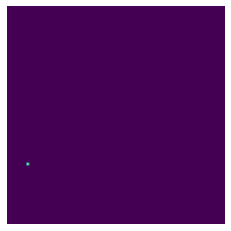

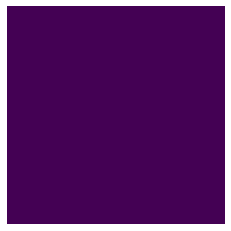

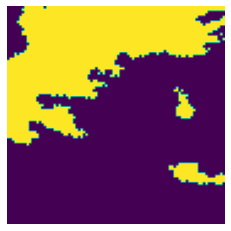

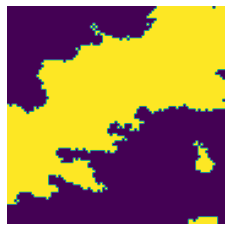

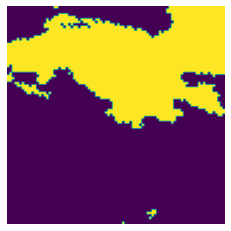

In [8]:
# Why isn't this giving us a result each time???
dl = DataLoader(ds, sampler=sampler2, collate_fn=stack_samples)

for sample in dl:
    mask = sample['mask']
    ds.plot(mask)

## Make a ConstrainedRandomBatchGeoSampler class

In [9]:
class ConstrainedRandomBatchGeoSampler(RandomBatchGeoSampler):
    """Returns batches of samples that meet the constraints specified:
        1. Proportion of samples with a burn proportion < 'burn_th': 'no_burn_prop'
        2. The rest of the samples will make up 1-'no_burn_prop' proportion and have a burn proportion > 'burn_th'
    
    Args:
        dataset: the dataset to take samples from.
        size: size of patch in lat/lon.
        batch_size: the number of batches to take per epoch. 
        length: number of samples (in total) to take per epoch. Note: this means samples per batch = length/batch_size.
        not_burned_prop: proportion of returned samples present that are "not burned". This may be no burn/some burn.
        burn_th: minimum threshold proportion required for a sample to be classed as "burned.
        roi: region of interest to take samples from.
        
    Returns: 
        constrained_samples: set of samples that meet the specified constraints.
    """

    # Setup the attributes required for constraint implementation 
    not_burned_samples_required = None
    burn_samples_required = None
    not_burned_prop = None
    burn_th = None
    
    # Define the constructor
    def __init__(
        self,
        dataset: GeoDataset,
        size: Union[Tuple[float, float], float],
        batch_size: int,
        length: int,
        not_burned_prop: float,
        burn_th: float,
        roi: Optional[BoundingBox] = None,
    ) -> None:
        
        # Use init from RandomBatchGeoSampler parent class
        super().__init__(dataset, size, batch_size, length)
        
        # Save the input constraints and dataset to the object
        self.dataset = dataset
        self.not_burned_prop = not_burned_prop
        self.burn_th = burn_th
        
        # Set the number of samples required of not burned/burned types
        # Note: len(self) = length/batch_size = number of samples per batch
        self.not_burned_samples_required = math.floor(not_burned_prop * len(self))
        self.burn_samples_required = len(self) - self.not_burned_samples_required
        
         
    def __iter__(self) -> Iterator[List[BoundingBox]]:
        """Defines a generator function of sets of areas to sample next. 
           Note: sets are defined as a set of samples where one sample is assigned to each batch. I.e. need len(self) sets
                 to complete all batches.
        
        Returns:
            List((minx, maxx, miny, maxy, mint, maxt)) coordinates to index a dataset
        """
        
        # Generate sets of samples until all batches are complete
        for _ in range(len(self)):
            
            # Choose a random tile
            hit = random.choice(self.hits)
            bounds = BoundingBox(*hit.bounds)

            # Initialise an empty set
            sample_set = []
                
            # Consider samples of the "not-burned" type if more are required
            if self.not_burned_samples_required != 0:
                
                # Keep generating random bounding boxes until set is full
                while len(sample_set) < self.batch_size:
                
                    # Choose a random sample within that tile
                    bounding_box = get_random_bounding_box(bounds, self.size, self.res)

                    # Verify that "not-burned" constraint is satisfied 
                    burn_prop = self.get_burn_proportion(bounding_box)
                    if burn_prop < self.burn_th:
                        sample_set.append(bounding_box)
                
                # Once the set is full, return the set 
                #print('No burn set:')
                self.not_burned_samples_required -= 1   
                yield sample_set
            
            # Consider samples of the "burn" type if more are required
            elif self.burn_samples_required != 0:
                
                # Keep generating random bounding boxes until set is full
                while len(sample_set) < self.batch_size:
                
                    # Choose a random sample within that tile
                    bounding_box = get_random_bounding_box(bounds, self.size, self.res)

                    # Verify that "burn" constraint is satisfied 
                    burn_prop = self.get_burn_proportion(bounding_box)
                    if burn_prop >= self.burn_th:
                        sample_set.append(bounding_box)

                # Once the set is full, return the set
                #print('Burn set:')
                self.burn_samples_required -= 1    
                yield sample_set
            
        # If all required samples generated, reset requirements for next call 
        self.not_burned_samples_required = math.floor(self.not_burned_prop * len(self))
        self.burn_samples_required = len(self) - self.not_burned_samples_required    
        
        
    def get_burn_proportion(self, bounding_box):
        """Returns the burn proportion found within a given bounding box.
        
        Returns:
            burn_prop: the burn proportion present within the bounding box. 
        """
        
        # Obtain the burn data within the bounding box
        burn_data = self.dataset[bounding_box]['mask']
        
        # Get burn proportion within the bounding box   
        non_zero_count = int((np.array(burn_data) > 0).sum())
        burn_prop = non_zero_count / burn_data.numel()
        return burn_prop

In [10]:
sampler3 = ConstrainedRandomBatchGeoSampler(ds, size=0.2, batch_size=2, length=6, not_burned_prop=0.5, burn_th=0.3)

Batch 0:


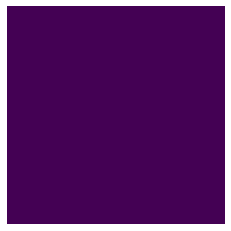

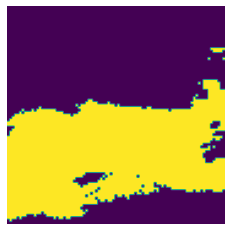

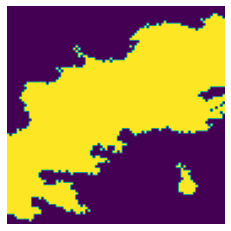

Batch 1:


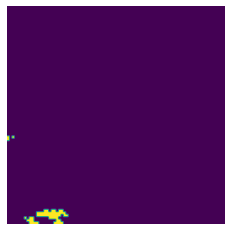

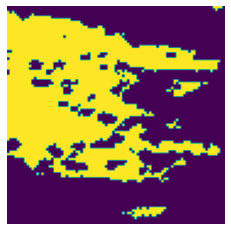

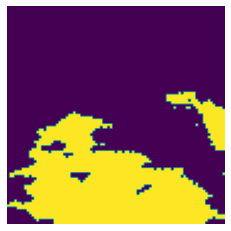

In [11]:
dl = DataLoader(ds, batch_sampler=sampler3, collate_fn=stack_samples)

print('Batch 0:')
for sample in dl:
    mask = sample['mask'][0]
    ds.plot(mask)
    
print('Batch 1:')
for sample in dl:
    mask = sample['mask'][1]
    ds.plot(mask)
    

To do: 
- clean up code and comments 
- upload notebook to github
- put custom sampler(s) in src
- get Sofija to integrate custom batch sampler 